In [1]:
# import warnings

import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [54]:
#import sqlalchemy so that we can connect to data in the db
import sqlalchemy as sa
import pandas as pd
from sqlalchemy import create_engine


Username = 'admin'
Password = 'amazing_people'
Host = 'alphacode-explore.ccwgqdqrrmvt.eu-west-1.rds.amazonaws.com'
Port = '1433'
Database = 'Andile'

connection = create_engine(
    'mssql+pymssql://' +
    Username + ':' + Password + '@' + Host + ':' + Port + '/' + Database
)


In [2]:
#Base packages

import numpy as np
import pandas as pd

In [3]:
#Scoring package
from sklearn.metrics import classification_report

In [4]:
#Visualisation packages

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 
import datetime

In [5]:
# Function is to look at the data on the dataframe as quick one-shot

def stats(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [6]:
def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

def my_file_read(file):
    df = pd.read_csv(file)
    print("{}: {} has {} observations and {} columns".format(now(), file, df.shape[0], df.shape[1]))
    print("{}: Column name checking::: {}".format(now(), df.columns.tolist()))
    return df

# Self-defined function to read dataframe and find the missing data on the columns and # of missing
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

In [70]:
# import data to perform preprocessing on it.

# Importing train  data from the db
sql_query1 = "Select * from claims_data"
raw_data = pd.read_sql_query(sql_query1, connection)

# Importing test data from the db
sql_query2 = "Select * from test_data"
predictor = pd.read_sql_query(sql_query2, connection)

#Combine data frames to clean both the same way 
combine_df = [raw_data, predictor]
df = pd.concat(combine_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 0 to 299
Data columns (total 10 columns):
age                1638 non-null int64
bmi                1638 non-null object
children           1638 non-null object
claim_amount       1338 non-null object
insurance_claim    1338 non-null object
region             1638 non-null object
row_id             300 non-null object
sex                1638 non-null object
smoker             1638 non-null object
steps              1638 non-null int64
dtypes: int64(2), object(8)
memory usage: 140.8+ KB


In [72]:
df['bmi'] = pd.to_numeric(df['bmi'])
df['claim_amount'] = pd.to_numeric(df['claim_amount'])
df.info()
raw_data['bmi'] = pd.to_numeric(raw_data['bmi'])
raw_data['claim_amount'] = pd.to_numeric(raw_data['claim_amount'])
predictor['bmi'] = pd.to_numeric(predictor['bmi'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 0 to 299
Data columns (total 10 columns):
age                1638 non-null int64
bmi                1638 non-null float64
children           1638 non-null object
claim_amount       1338 non-null float64
insurance_claim    1338 non-null object
region             1638 non-null object
row_id             300 non-null object
sex                1638 non-null object
smoker             1638 non-null object
steps              1638 non-null int64
dtypes: float64(2), int64(2), object(6)
memory usage: 140.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 0 to 299
Data columns (total 10 columns):
age                1638 non-null int64
bmi                1638 non-null float64
children           1638 non-null object
claim_amount       1338 non-null float64
insurance_claim    1338 non-null object
region             1638 non-null object
row_id             300 non-null object
sex                1638 non-null object
smoke

In [73]:
details = stats(raw_data, 'claim_amount')
display(details.sort_values(by='corr claim_amount', ascending=False))

Data shape: (1338, 9)
___________________________
Data types:
 object     5
float64    2
int64      2
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr claim_amount
claim_amount,float64,1338,783,0,0.000,"[[16884.924, 1725.5523, 0.0, 3866.8552, 8240.5...",1.580,1.596,1.000
bmi,float64,1338,548,0,0.000,"[[27.9, 33.77, 33.0, 22.705, 28.88, 25.74, 33....",0.284,-0.051,0.293
age,int64,1338,47,0,0.000,"[[19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, ...",0.056,-1.245,0.219
steps,int64,1338,55,0,0.000,"[[3009, 3008, 10009, 8010, 8005, 3002, 8007, 8...",0.662,-1.149,-0.347
sex,object,1338,2,0,0.000,"[[female, male]]",nan,nan,nan
children,object,1338,6,0,0.000,"[[0, 1, 3, 2, 5, 4]]",0.938,0.202,nan
smoker,object,1338,2,0,0.000,"[[yes, no]]",nan,nan,nan
region,object,1338,4,0,0.000,"[[southwest, southeast, northwest, northeast]]",nan,nan,nan
insurance_claim,object,1338,2,0,0.000,"[[yes, no]]",nan,nan,nan


In [74]:
print(checking_na(predictor))

Empty DataFrame
Columns: [df_bool, df_amt, missing_ratio_percent]
Index: []


In [75]:
print(raw_data.head(5))
print(raw_data.describe())
print(raw_data.info())

   age     sex    bmi  steps children smoker     region insurance_claim  \
0   19  female 27.900   3009        0    yes  southwest             yes   
1   18    male 33.770   3008        1     no  southeast             yes   
2   28    male 33.000   3009        3     no  southeast              no   
3   33    male 22.705  10009        0     no  northwest              no   
4   32    male 28.880   8010        0     no  northwest             yes   

   claim_amount  
0     16884.924  
1      1725.552  
2         0.000  
3         0.000  
4      3866.855  
           age      bmi     steps  claim_amount
count 1338.000 1338.000  1338.000      1338.000
mean    39.207   30.663  5328.623      9611.312
std     14.050    6.098  2453.643     13450.624
min     18.000   15.960  3000.000         0.000
25%     27.000   26.296  3008.000         0.000
50%     39.000   30.400  4007.000      2748.484
75%     51.000   34.694  8004.000     13045.980
max     64.000   53.130 10010.000     63770.428
<class 'p

yes    783
no     555
Name: insurance_claim, dtype: int64


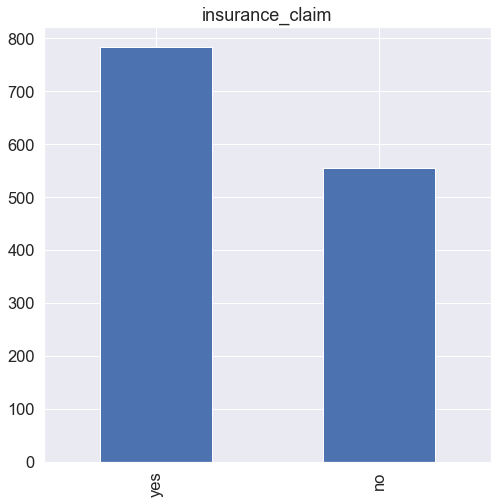

In [76]:
print(raw_data.insurance_claim.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
raw_data.insurance_claim.value_counts().plot(kind='bar', title="insurance_claim", ax=ax, figsize=(8,8))
plt.show()

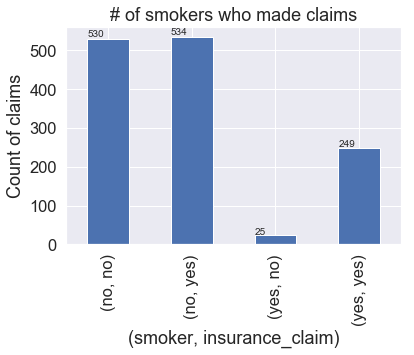

In [77]:
ax = raw_data.groupby(['smoker', 'insurance_claim']).size().plot(kind='bar')
ax.set_title("# of smokers who made claims")
ax.set_xlabel("(smoker, insurance_claim)")
ax.set_ylabel("Count of claims")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

   age    bmi children  claim_amount insurance_claim     region row_id  \
0   19 27.900        0     16884.924             yes  southwest    NaN   
1   18 33.770        1      1725.552             yes  southeast    NaN   
2   28 33.000        3         0.000              no  southeast    NaN   
3   33 22.705        0         0.000              no  northwest    NaN   
4   32 28.880        0      3866.855             yes  northwest    NaN   

      sex smoker  steps  
0  female    yes   3009  
1    male     no   3008  
2    male     no   3009  
3    male     no  10009  
4    male     no   8010  


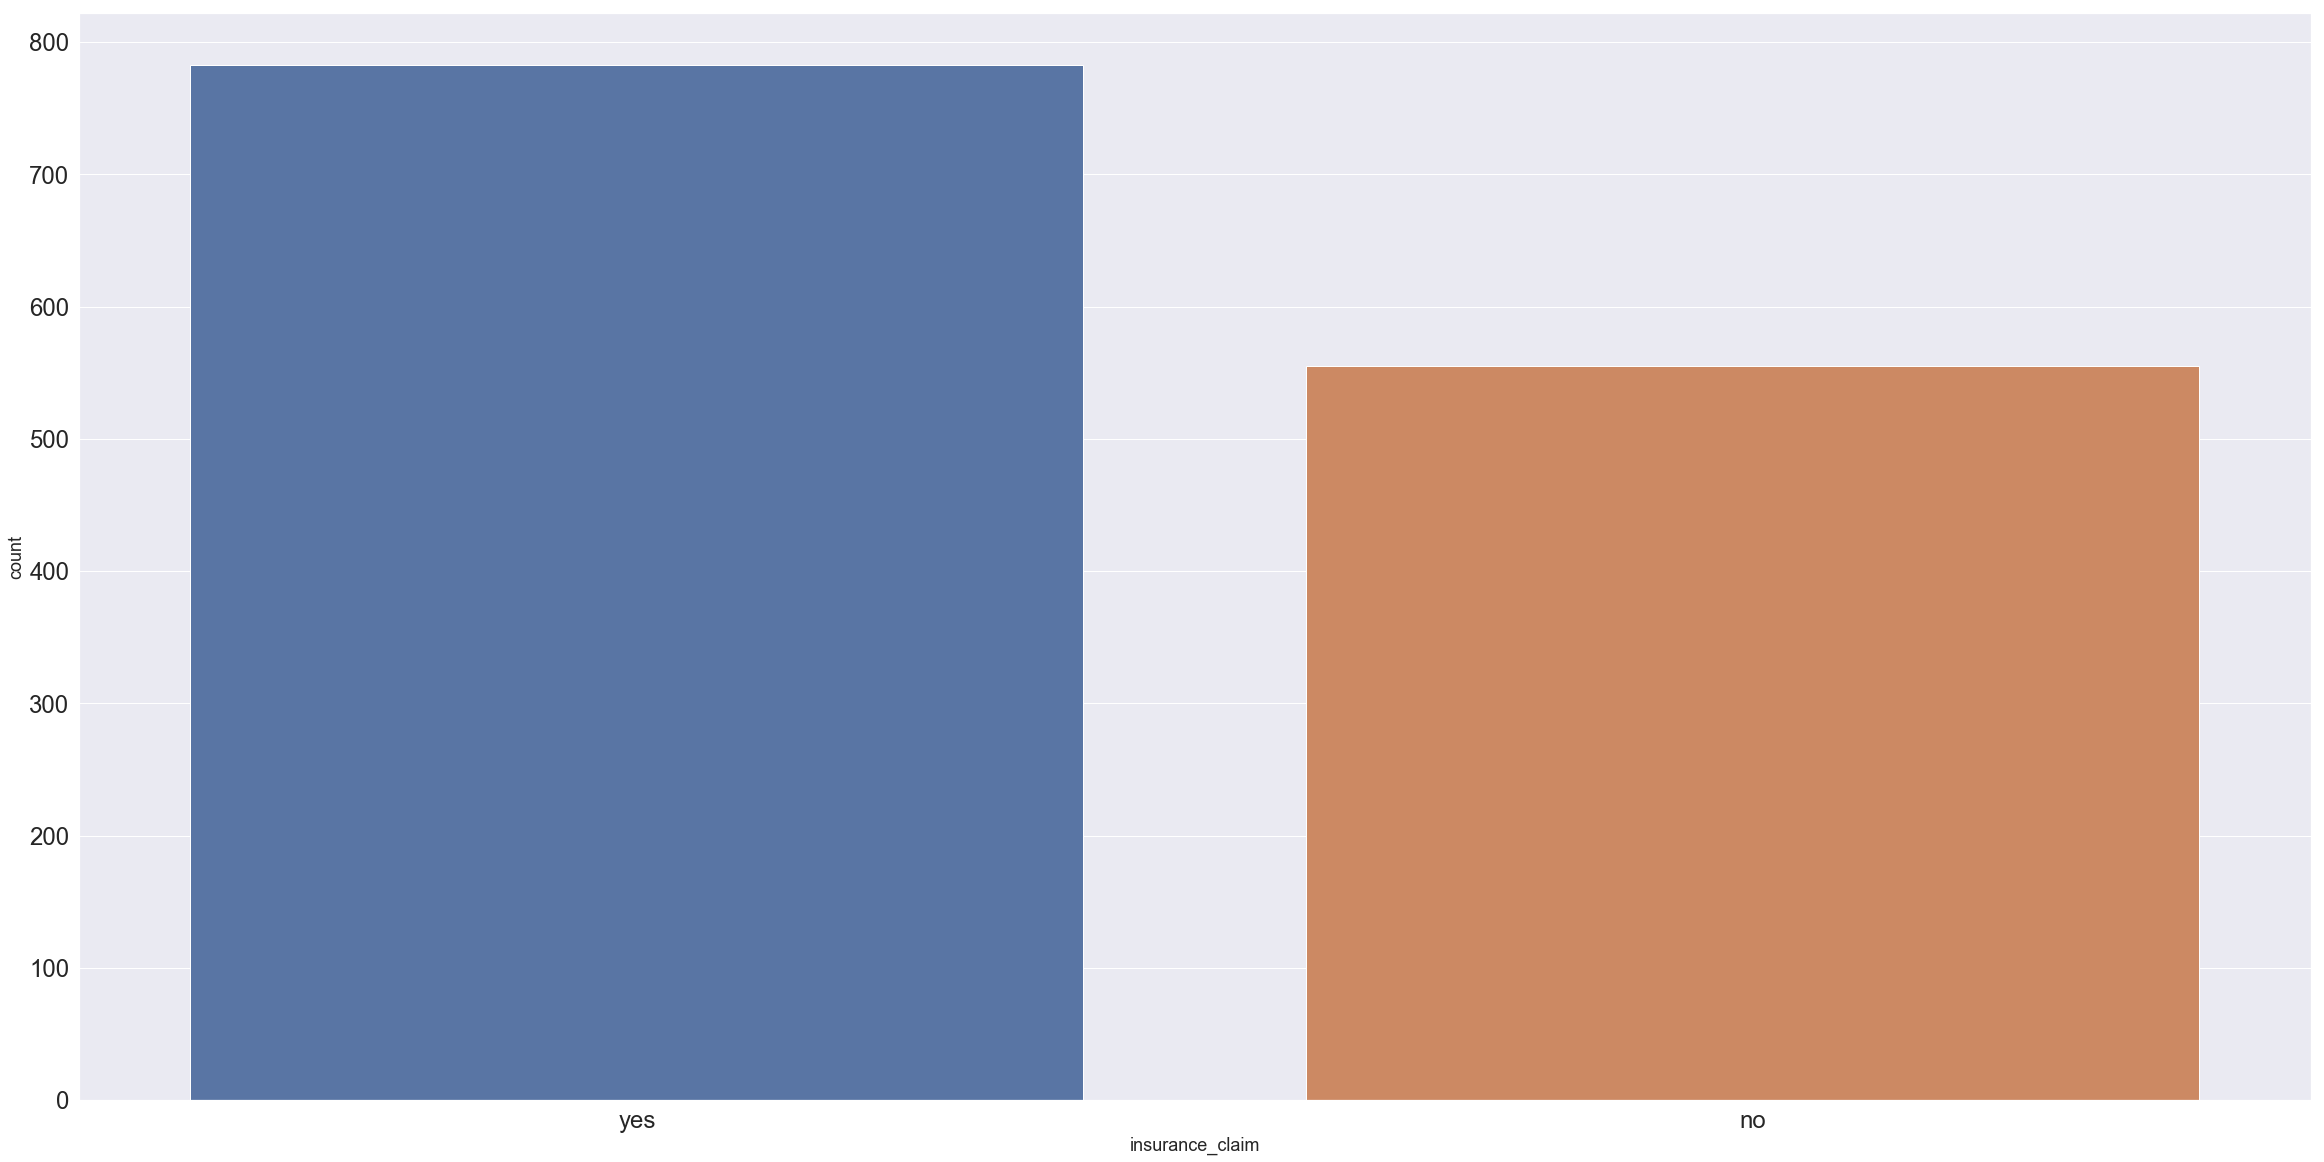

In [78]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=df, x='insurance_claim')
print(df.head())

Gender types ['male' 'female']


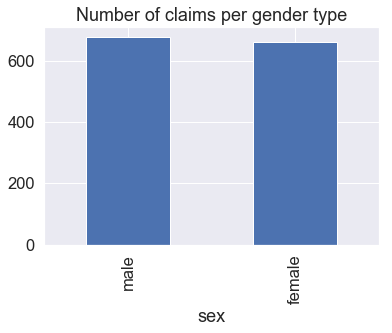

In [120]:
dist = df['sex'].value_counts()
dist

groups = df.groupby("sex").count()
groups.sort_values("insurance_claim", ascending=False, inplace=True)
print ("Gender types", groups.index.values)

#Priors used below for Random Guessing Estimation
priors = groups["insurance_claim"] / groups["insurance_claim"].sum()
groups["insurance_claim"].plot(kind="bar", title="Number of claims per gender type")

Regions ['southeast' 'northwest' 'southwest' 'northeast']


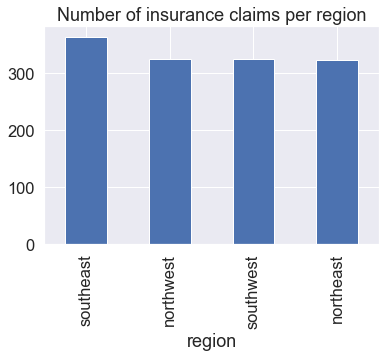

In [119]:
dist = df['region'].value_counts()
dist

groups = df.groupby("region").count()
groups.sort_values("insurance_claim", ascending=False, inplace=True)
print ("Regions", groups.index.values)

#Priors used below for Random Guessing Estimation
priors = groups["insurance_claim"] / groups["insurance_claim"].sum()
groups["insurance_claim"].plot(kind="bar", title="Number of insurance claims per region")

Age groups [18 19 20 45 46 47 48 50 51 52 21 49 53 28 27 26 25 24 23 22 54 42 44 43
 41 40 29 30 31 32 57 56 55 33 34 35 36 37 38 39 58 59 62 63 60 61 64 65
 66 67 68]


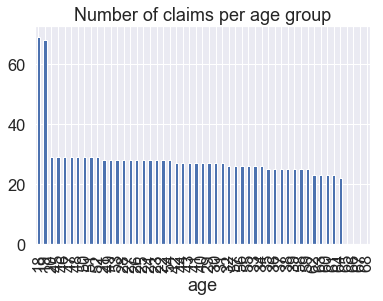

In [118]:
dist = df['age'].value_counts()
dist

groups = df.groupby("age").count()
groups.sort_values("insurance_claim", ascending=False, inplace=True)
print ("Age groups", groups.index.values)

#Priors used below for Random Guessing Estimation
priors = groups["insurance_claim"] / groups["insurance_claim"].sum()
groups["insurance_claim"].plot(kind="bar", title="Number of claims per age group")

Smokers ['no' 'yes']


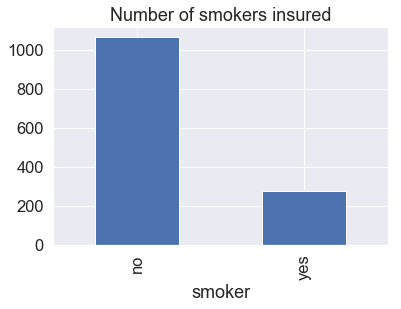

In [116]:
dist = df['smoker'].value_counts()
dist

groups = df.groupby("smoker").count()
groups.sort_values("insurance_claim", ascending=False, inplace=True)
print ("Smokers", groups.index.values)

#Priors used below for Random Guessing Estimation
priors = groups["insurance_claim"] / groups["insurance_claim"].sum()
groups["insurance_claim"].plot(kind="bar", title="Number of smokers insured")

Children ['0' '1' '2' '3' '4' '5']


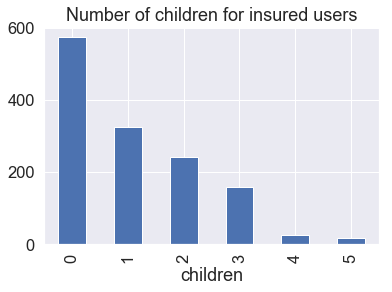

In [117]:
dist = df['children'].value_counts()
dist

groups = df.groupby("children").count()
groups.sort_values("insurance_claim", ascending=False, inplace=True)
print ("Children", groups.index.values)

#Priors used below for Random Guessing Estimation
priors = groups["insurance_claim"] / groups["insurance_claim"].sum()
groups["insurance_claim"].plot(kind="bar", title="Number of children for insured users")

In [84]:
df.head

<bound method NDFrame.head of      age    bmi children  claim_amount insurance_claim     region row_id  \
0     19 27.900        0     16884.924             yes  southwest    NaN   
1     18 33.770        1      1725.552             yes  southeast    NaN   
2     28 33.000        3         0.000              no  southeast    NaN   
3     33 22.705        0         0.000              no  northwest    NaN   
4     32 28.880        0      3866.855             yes  northwest    NaN   
5     31 25.740        0         0.000              no  southeast    NaN   
6     46 33.440        1      8240.590             yes  southeast    NaN   
7     37 27.740        3         0.000              no  northwest    NaN   
8     37 29.830        2         0.000              no  northeast    NaN   
9     60 25.840        0         0.000              no  northwest    NaN   
10    25 26.220        0      2721.321             yes  northeast    NaN   
11    62 26.290        0     27808.725             yes  so

In [85]:
y = raw_data.insurance_claim.values
X = raw_data.drop(['insurance_claim','claim_amount'], axis=1)

In [86]:
X_transformed = pd.get_dummies(X, sparse=False, drop_first=True)
X_transformed.head()

,age,bmi,steps,sex_male,children_1,children_2,children_3,children_4,children_5,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,3009,0,0,0,0,0,0,1,0,0,1
1,18,33.770,3008,1,1,0,0,0,0,0,0,1,0
2,28,33.000,3009,1,0,0,1,0,0,0,0,1,0
3,33,22.705,10009,1,0,0,0,0,0,0,1,0,0
4,32,28.880,8010,1,0,0,0,0,0,0,1,0,0


In [87]:
# Split the training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state = 47)

In [88]:
from sklearn.linear_model import LogisticRegression
#Simple Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lm_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

85.14

In [89]:
print(classification_report(y_test, lm_pred))

              precision    recall  f1-score   support

          no       0.80      0.84      0.82       102
         yes       0.90      0.87      0.89       166

    accuracy                           0.86       268
   macro avg       0.85      0.86      0.85       268
weighted avg       0.86      0.86      0.86       268



In [90]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
#Support Vector Machine
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

89.07

In [91]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

          no       0.74      0.69      0.71       102
         yes       0.82      0.85      0.83       166

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [92]:
from sklearn.neighbors import KNeighborsClassifier
#K Nearest Neighbours Classifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

86.26

In [93]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

          no       0.64      0.70      0.67       102
         yes       0.80      0.76      0.78       166

    accuracy                           0.74       268
   macro avg       0.72      0.73      0.72       268
weighted avg       0.74      0.74      0.74       268



In [94]:
from sklearn.naive_bayes import GaussianNB
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
gnb_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

78.97

In [95]:
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

          no       0.77      0.76      0.77       102
         yes       0.86      0.86      0.86       166

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



In [96]:
from sklearn.linear_model import Perceptron
# Perceptron

perceptron = Perceptron(penalty='elasticnet', alpha=0.0001)
perceptron.fit(X_train, y_train)
ptn_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

57.66

In [97]:
print(classification_report(y_test, ptn_pred))

              precision    recall  f1-score   support

          no       0.00      0.00      0.00       102
         yes       0.62      1.00      0.76       166

    accuracy                           0.62       268
   macro avg       0.31      0.50      0.38       268
weighted avg       0.38      0.62      0.47       268



In [98]:
from sklearn.svm import SVC, LinearSVC
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
lsvc_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

42.34

In [99]:
print(classification_report(y_test, lsvc_pred))

              precision    recall  f1-score   support

          no       0.38      1.00      0.55       102
         yes       0.00      0.00      0.00       166

    accuracy                           0.38       268
   macro avg       0.19      0.50      0.28       268
weighted avg       0.14      0.38      0.21       268



In [100]:
from sklearn.linear_model import SGDClassifier
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

42.34

In [101]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

          no       0.38      1.00      0.55       102
         yes       0.00      0.00      0.00       166

    accuracy                           0.38       268
   macro avg       0.19      0.50      0.28       268
weighted avg       0.14      0.38      0.21       268



In [102]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
tree_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

100.0

In [103]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

          no       0.99      0.99      0.99       102
         yes       0.99      0.99      0.99       166

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



In [104]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

In [105]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       102
         yes       0.96      0.96      0.96       166

    accuracy                           0.96       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.96      0.96      0.96       268



In [106]:
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
PassAgg = PassiveAggressiveClassifier(max_iter=50)

sgd = SGDClassifier(loss='hinge',   
              penalty='l1',   
              alpha=1e-2,     
              random_state=42,
              max_iter=7,     
              tol=None)

In [107]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       102
         yes       0.96      0.96      0.96       166

    accuracy                           0.96       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.96      0.96      0.96       268



In [108]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.000
8,Decision Tree,100.000
0,Support Vector Machines,89.070
1,KNN,86.260
2,Logistic Regression,85.140
4,Naive Bayes,78.970
5,Perceptron,57.660
6,Stochastic Gradient Decent,42.340
7,Linear SVC,42.340


In [109]:
X_submission = predictor.drop('row_id', axis=1)

In [110]:
X_submission_transformed = pd.get_dummies(X_submission, sparse=False, drop_first=True)
X_submission_transformed.head()

,age,bmi,steps,sex_male,children_1,children_2,children_3,children_4,children_5,smoker_yes,region_northwest,region_southeast,region_southwest
0,27,28.880,8049,1,0,0,0,0,0,0,0,0,1
1,20,26.265,7970,0,0,0,1,0,0,1,0,0,1
2,32,26.025,2973,0,0,0,0,0,0,0,0,0,1
3,19,22.085,10427,0,1,0,0,0,0,1,0,0,1
4,20,28.685,3972,0,0,0,0,0,0,1,0,0,1


In [111]:
predictions = random_forest.predict(X_submission_transformed)

In [112]:
submission = pd.DataFrame({'row_id' : predictor.row_id,'predictions' : predictions.ravel()}) 
submission.to_csv('submission.csv', index=False)

In [113]:
submission.head()

,row_id,predictions
0,1,yes
1,2,yes
2,3,yes
3,4,yes
4,5,yes


In [114]:
submission.to_sql('classification_model_results', con=connection, if_exists='append', index=False,method='multi',chunksize=500)